# Figure 1
This is a side-by-side plot of the flight tracks from the campaign with a satellite image showing a typical cold-air outbreak from the campaign. 

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.shapereader import Reader
from matplotlib.patches import Patch
import cdsapi
from PIL import Image

In [2]:
NPS = ccrs.NorthPolarStereo(central_longitude=15)
PC = ccrs.PlateCarree()

In [3]:
def convert_to_spm(time):
    h, m, s = time.split(':')
    return int(h)*3600 + int(m) * 60 + int(s)

In [4]:
def create_map_basis(ax):
    ax.set_extent([0, 30, 66, 82], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=PC, zorder=6, draw_labels=True, x_inline = False,
                      y_inline = False, linewidth=0.5, linestyle=(0, (5, 1)))
    gl.n_steps = 60
    gl.ylocator = mticker.FixedLocator(np.arange(60, 90, 2))
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(-20, 61, 5))
    gl.xformatter = LONGITUDE_FORMATTER
    
    gl.ylabel_style = {'fontsize': 10, 'zorder': 6, 'rotation':0, 'color': 'k'}
    gl.xlabel_style = {'fontsize': 10, 'zorder': 6, 'rotation':0, 'color': 'k'}
    gl.top_labels = False
    gl.right_labels = False

In [5]:
def make_map_elements(ax,add=True):
    # Find paths to the sea-ice shapefiles for the maximum and minimum sea-ice extent
    max_ice_path = '/home/users/erinraif/acao_data/sea_ice_shapefiles/20220311_c271/masie_ice_r00_v01_2022070_1km.shp'
    min_ice_path = '/home/users/erinraif/acao_data/sea_ice_shapefiles/20220330_c281_c282/masie_ice_r00_v01_2022089_1km.shp'
    
    # define the coastlines, oceans and land shapes
    coasts_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', 
                                              edgecolor='black',
                                              facecolor= 'none')
    
    ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                            edgecolor='face',
                                            facecolor='lightblue')
    
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='lightgray')
    
    # Create sea-ice features
    max_ice = cfeature.ShapelyFeature(Reader(max_ice_path).geometries(),
                                             ccrs.NorthPolarStereo(central_longitude = -80, 
                                             true_scale_latitude = 60), facecolor = 'azure',
                                             edgecolors = 'red', linestyle='--')
    
    min_ice = cfeature.ShapelyFeature(Reader(min_ice_path).geometries(),
                                             ccrs.NorthPolarStereo(central_longitude = -80, 
                                             true_scale_latitude = 60), facecolor = 'azure',
                                             edgecolors = 'red', linestyle='-')
    
    # add all to the map
    if add:
        ax.add_feature(ocean_50m, zorder = 1, alpha = 0.4)
        ax.add_feature(max_ice, zorder = 3, linewidth = 0.5)
        ax.add_feature(min_ice, zorder = 2, linewidth = 0.5)
        ax.add_feature(land_50m, zorder = 4, alpha = 0.4)
        ax.add_feature(coasts_50m, zorder = 5, linewidth = 0.5)

In [6]:
def plot_flight_track(flight_id,ax,**kwargs):
    flight_data = xr.open_dataset(
                    glob('/badc/faam/data/2022/'+
                         flight_id+'*/core_processed/core_faam*'
                         +flight_id+'.nc')[-1], decode_times=False, engine='netcdf4')
    ax.plot(flight_data.LON_GIN[:,0], flight_data.LAT_GIN[:,0],
        transform = PC, **kwargs)
    return
    

In [7]:
def plot_c280_filter(ax, c280_data, start_time, end_time, **kwargs):
    clip = c280_data.sel(Time=slice(convert_to_spm(start_time),
                           convert_to_spm(end_time)))
    ax.plot(clip.LON_GIN[:,0], clip.LAT_GIN[:,0],
        transform = PC, **kwargs)
    return

In [8]:
# Retreieve reanalysis data at the appropriate time, save to NetCDF and read.
c = cdsapi.Client()
c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': 'mean_sea_level_pressure',
        'year': '2022',
        'month': '03',
        'day': '29',
        'time': '10:00',
        'area': [ #NWSE
            82.5, -25, 66,
            55, 
        ],
        'format': 'netcdf',
    },
    r'./era5_data/fig1_pressure0329_data.nc')
pressure_data = xr.open_dataset(r'./era5_data/fig1_pressure0329_data.nc')
#pressure_data

2024-09-07 11:56:12,985 INFO Welcome to the CDS.
As per our announcements on the Forum, this instance of CDS will be decommissioned on 26 September 2024 and will no longer be accessible from this date onwards.
Please update your cdsapi package to a version >=0.7.2, create an account on CDS-Beta and update your .cdsapirc file. We strongly recommend users to check our Guidelines at https://confluence.ecmwf.int/x/uINmFw
2024-09-07 11:56:12,987 WARNING MOVE TO CDS-Beta
2024-09-07 11:56:12,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-09-07 11:56:13,160 INFO Request is queued
2024-09-07 12:16:32,732 INFO Request is completed
2024-09-07 12:16:32,734 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data2/adaptor.mars.internal-1725711340.1843932-22266-4-4f7a921d-7c4e-4fdc-9caf-89b3ee2c0937.nc to ./era5_data/fig1_pressure0329_data.nc (44.6K)
2024-09-07 12:16:33,013 INFO Download rate 1

**Weird error that some people may have to correct** *(it's the only one, I promise!)*. NASA seemingly changed their server-side handling of WMTS objects which made wmts.py in OWSLib stop working in all versions after I'd already made this figure! To make it work, you need to change line 236 in OWSLib/wmts.py to remove the RaiseError and replace with a warning 

```
msg = ('Content metadata for layer "%s" '
        'already exists' % cm.id)
                            
warnings.warn(msg, RuntimeWarning)
```

/home/users/erinraif/nb_envs/mphase/lib/python3.11/site-packages/owslib/wmts.py:647: RuntimeWarning: TileMatrixLimits with tileMatrix "1" already exists
  warnings.warn(msg, RuntimeWarning)
/home/users/erinraif/nb_envs/mphase/lib/python3.11/site-packages/owslib/wmts.py:647: RuntimeWarning: TileMatrixLimits with tileMatrix "2" already exists
  warnings.warn(msg, RuntimeWarning)
/home/users/erinraif/nb_envs/mphase/lib/python3.11/site-packages/owslib/wmts.py:647: RuntimeWarning: TileMatrixLimits with tileMatrix "3" already exists
  warnings.warn(msg, RuntimeWarning)
/home/users/erinraif/nb_envs/mphase/lib/python3.11/site-packages/owslib/wmts.py:647: RuntimeWarning: TileMatrixLimits with tileMatrix "4" already exists
  warnings.warn(msg, RuntimeWarning)
/home/users/erinraif/nb_envs/mphase/lib/python3.11/site-packages/owslib/wmts.py:647: RuntimeWarning: TileMatrixLimits with tileMatrix "5" already exists
  warnings.warn(msg, RuntimeWarning)
/home/users/erinraif/nb_envs/mphase/lib/python3.11

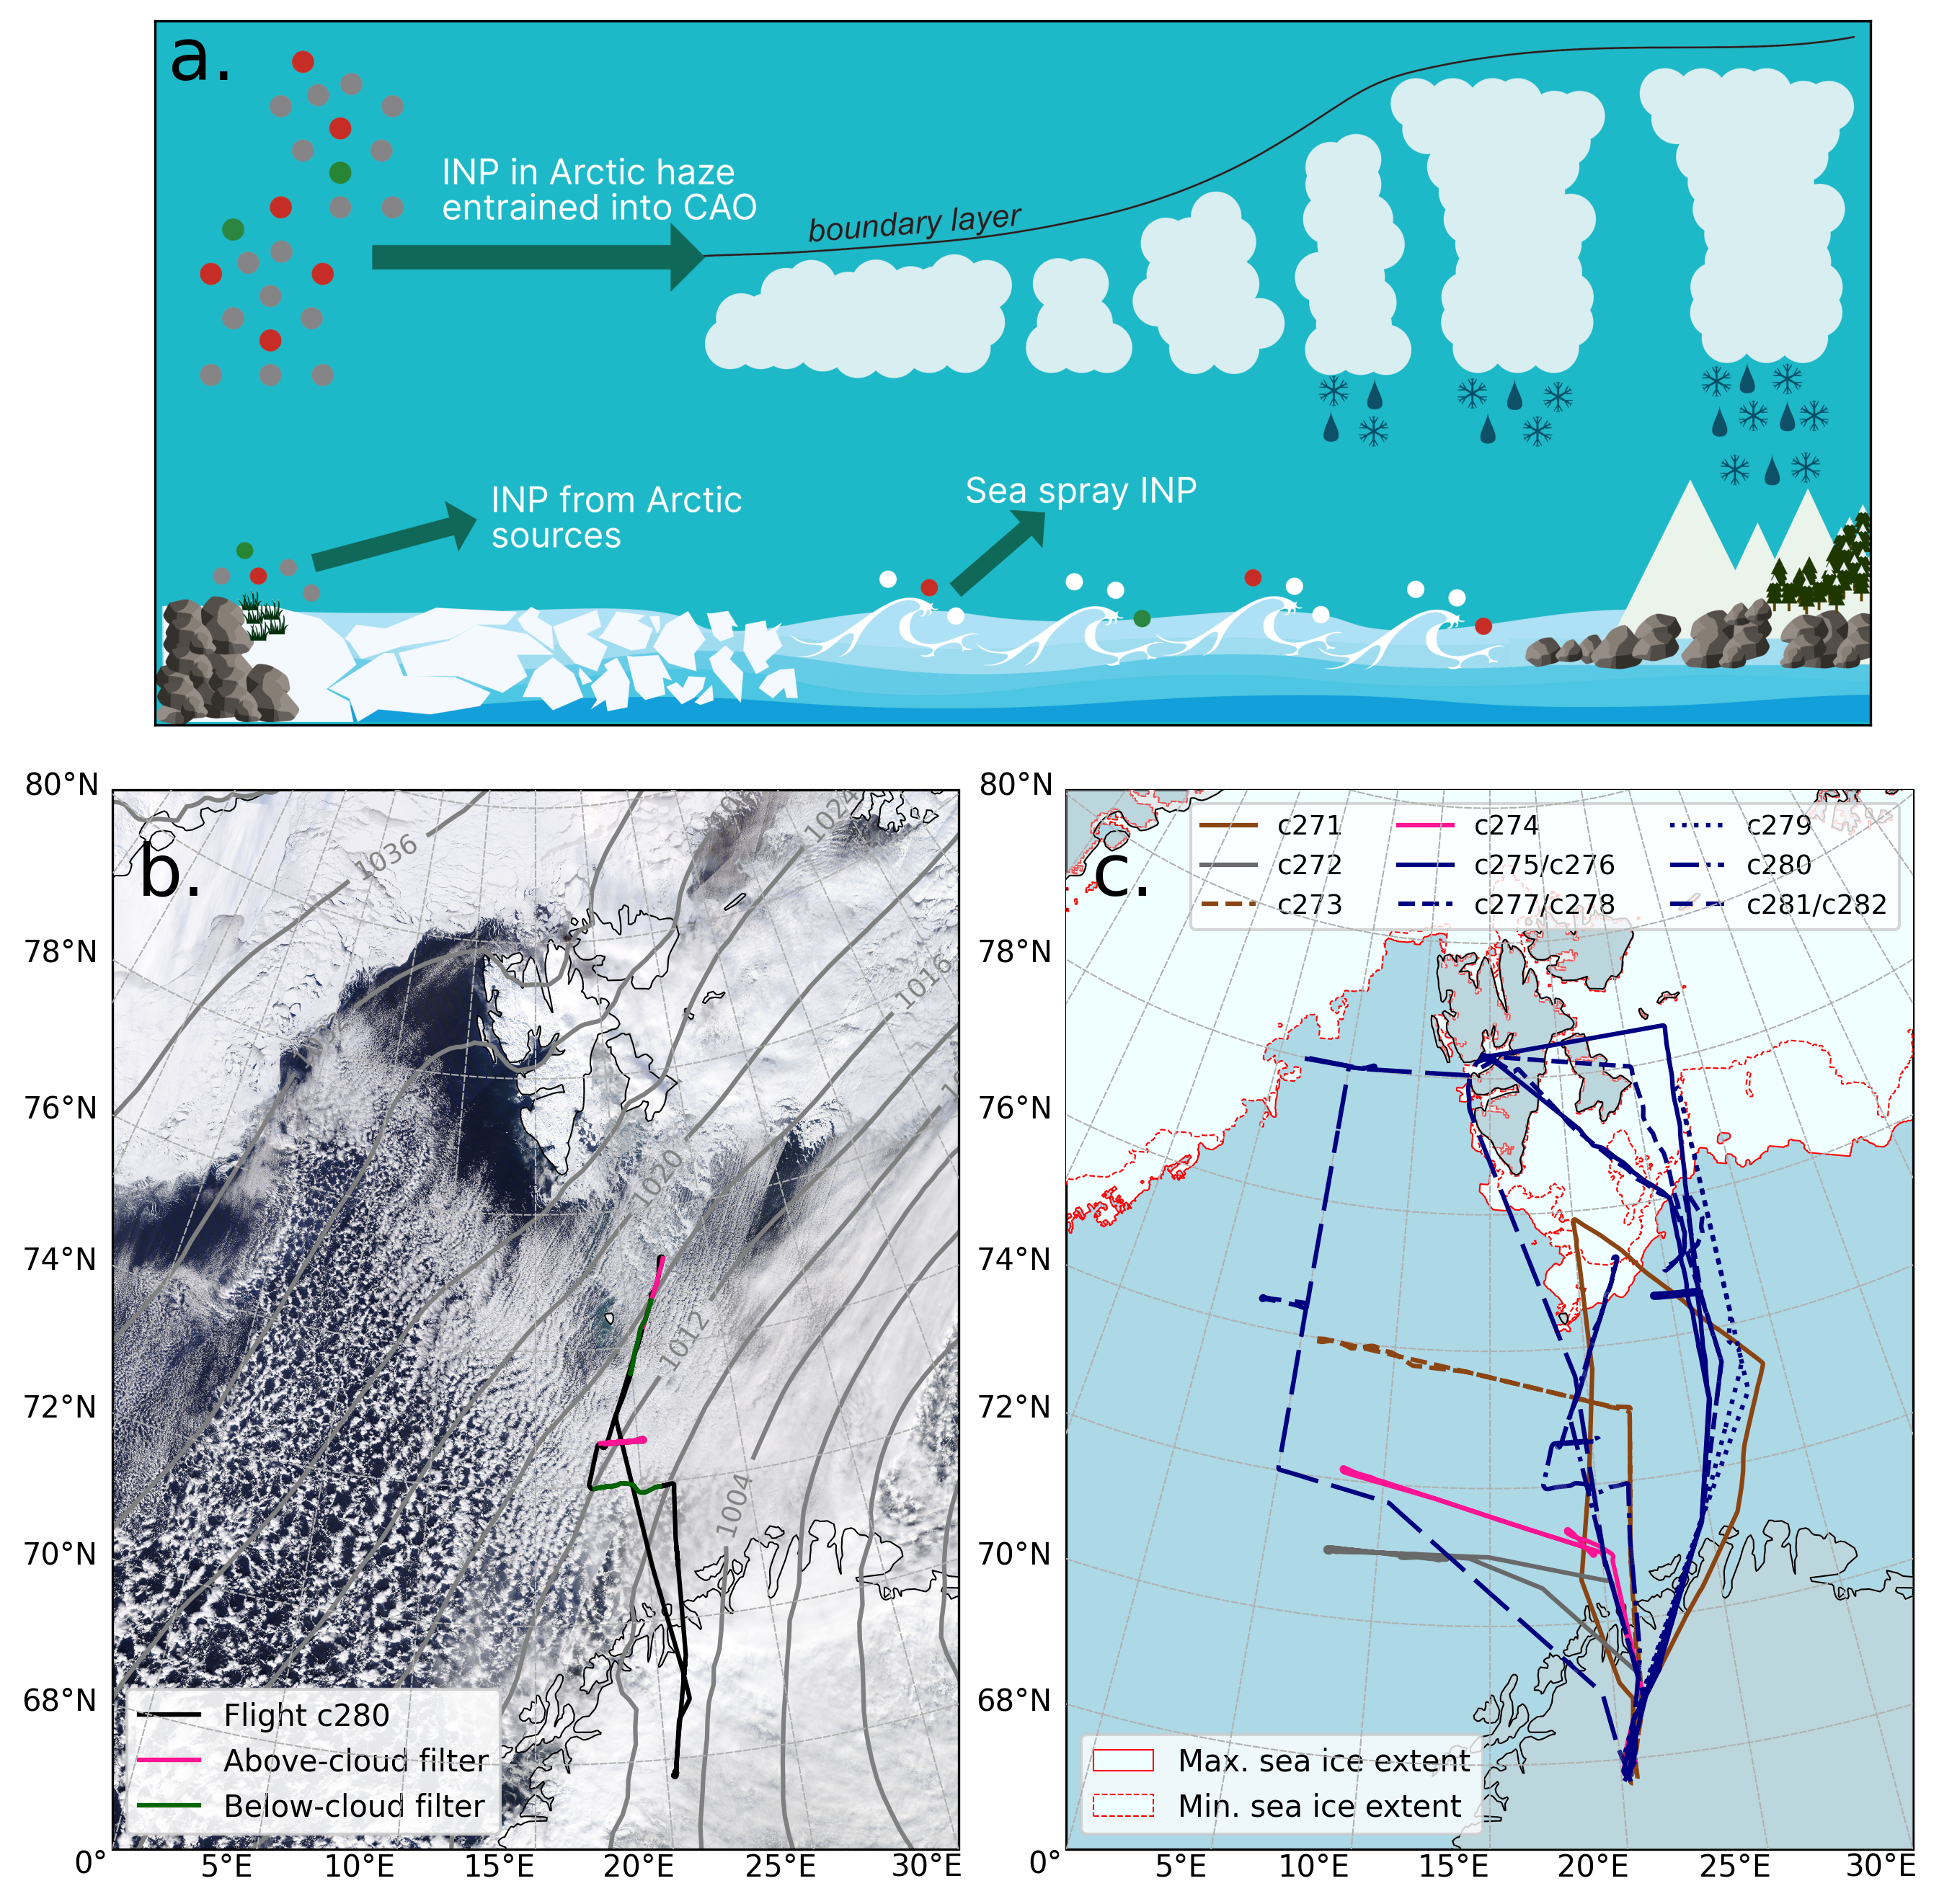

In [10]:
# Note that this needs matplotlib 3.7 or later for per_subplot_kw to work
# Axes have strange labels, I know, because I started with C at the bottom and B on the left.
pressure_data = xr.open_dataset(r'./era5_data/fig1_pressure0329_data.nc')
fig, axes = plt.subplot_mosaic(
            """
            CCCC
            CCCC
            BBAA
            BBAA
            BBAA
            """,
            figsize=(9,9), dpi=300,
            per_subplot_kw = {
                ("A","B"): {'projection': NPS}
            })

# Add sketch to bottom axes and remove ticks as not a graph
im_C = np.asarray(Image.open('sketches/cao_schematic_V2.png'))
axes['C'].imshow(im_C)
axes['C'].set_xticks([])
axes['C'].set_yticks([])

# Retrieve satellite imagery
dateiso = '2022-03-29'
product = 'MODIS_Terra_CorrectedReflectance_TrueColor'
wmt_url = 'https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi'

for ax in [axes['A'], axes['B']]:
    # Create map gridlines etc.
    create_map_basis(ax)

# Add Satellite Imagery
axes['B'].add_wmts(wmt_url, product, wmts_kwargs={'time': dateiso})

# Add sea-ice, borders, etc to panel (c)
make_map_elements(axes['A'])

# Plot flight tracks, only labelling the first of each double-flight.
plot_flight_track('c271',axes['A'],linewidth = 1.5, linestyle='-',
                  color='saddlebrown', zorder = 7, label='c271')
plot_flight_track('c272',axes['A'],linewidth = 1.5, linestyle='-',
                  color='dimgray', zorder = 8, label='c272')
plot_flight_track('c273',axes['A'],linewidth = 1.5, linestyle='--',
                  color='saddlebrown', zorder = 9, label='c273')
plot_flight_track('c274',axes['A'],linewidth = 1.5, linestyle='-',
                  color='deeppink', zorder = 10, label='c274')
plot_flight_track('c275',axes['A'],linewidth = 1.5, linestyle='-',
                  color='navy', zorder = 11, label='c275/c276')
plot_flight_track('c276',axes['A'],linewidth = 1.5, linestyle='-',
                  color='navy', zorder = 11)
plot_flight_track('c277',axes['A'],linewidth = 1.5, linestyle='--',
                  color='navy', zorder = 12, label='c277/c278')
plot_flight_track('c278',axes['A'],linewidth = 1.5, linestyle='--',
                  color='navy', zorder = 12)
plot_flight_track('c279',axes['A'],linewidth = 1.5, linestyle=':',
                  color='navy', zorder = 13, label='c279')
plot_flight_track('c280',axes['A'],linewidth = 1.5, linestyle='-.',
                  color='navy', zorder = 14, label='c280')
plot_flight_track('c281',axes['A'],linewidth = 1.5, linestyle=(5,(10,3)),
                  color='navy', zorder = 15, label='c281/c282')
plot_flight_track('c282',axes['A'],linewidth = 1.5, linestyle=(5,(10,3)),
                  color='navy', zorder = 12)

legend1 = axes['A'].legend(loc="upper right",ncol=3,fontsize=9)

# Keep legend permanently as-is
axes['A'].add_artist(legend1)

# Create second legend to show sea-ice.
second_legend_elements = [
    Patch(facecolor='azure', edgecolor='red', linestyle='-', linewidth=0.5,
          label='Max. sea ice extent'),
    Patch(facecolor='azure', edgecolor='red', linestyle='--', linewidth=0.5,
          label='Min. sea ice extent'),
]

legend2 = axes['A'].legend(handles=second_legend_elements, loc='lower left',fontsize=10)

# Add coastlines to panel (b)
coasts_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                                      edgecolor='black',
                                      facecolor='none')
axes['B'].add_feature(coasts_50m, linewidth=0.5)

# Plot c280 track and filters on panel (b)
plot_flight_track('c280',axes['B'],linewidth = 1.5, linestyle='-',
                  color='k', zorder = 14, label='Flight c280')

c280_data = xr.open_dataset(
                    glob('/badc/faam/data/2022/'+
                         'c280*/core_processed/core_faam*'
                         'c280.nc')[-1], decode_times=False, engine='netcdf4')
plot_c280_filter(axes['B'], c280_data, '09:29:00', '09:49:17',
                color='deeppink',zorder=15,label='Above-cloud filter')
plot_c280_filter(axes['B'], c280_data, '09:59:55', '10:15:58',
                 color='darkgreen',zorder=15,label='Below-cloud filter')
plot_c280_filter(axes['B'], c280_data, '10:34:01', '10:54:06',
                color='deeppink',zorder=15)
plot_c280_filter(axes['B'], c280_data, '11:05:35', '11:24:51',
                 color='darkgreen',zorder=15)

axes['B'].legend(loc="lower left",fontsize=10, framealpha=0.9)

lats = pressure_data['latitude'].values
lons = pressure_data['longitude'].values

# Extract surface pressure values (msl)
pressure = pressure_data['msl'].values[0]/100

# Define the levels for the isobars
pressure_levels = np.arange(980,1050,4)

# Create a contour plot on ax2
contour = axes['B'].contour(lons, lats, pressure, levels=pressure_levels, colors='grey', transform=ccrs.PlateCarree())

clabels = plt.clabel(contour, inline=True, fontsize=9, fmt='%d',inline_spacing=5)

axes['A'].text(-17.5,79,"c.",size=24,transform=PC)
axes['B'].text(-17.5,79,"b.",size=24,transform=PC)
axes['C'].text(40,180,"a.",size=24)

fig.tight_layout()
fig.savefig('./imgs/f01.png')